![Logo](../assets/logo.png)

Made by **Domonkos Nagy**

[<img src="../assets/open_button.png">](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/8.%20Function%20Approximation/tile_coding.ipynb)

# Tile Coding

Tile coding is a simple function approximation method that involves splitting a continuous space to a finite number of regions.
The simplest form of tile coding would be state aggregation: the left side of the figure below shows
a 2-dimensional space partitioned into 16 distinct regions. A partitioning like this is called a *tiling*, and each partition
of a tiling is called a *tile*: each tile has some value associated with it, wich can be learned.
If just this single tiling were used, then the
state indicated by the white spot would be represented by the single feature whose tile
it falls within; generalization would be complete to all states within the same tile and
nonexistent to states outside it.

To achieve better generalization, we can use multiple different tilings: the right side of the figure below shows the same space
with 4 tilings, each of them offset by a small amount. To approximate some function at any point in the space, the values
of the tiles that the point falls inside are simply added up.

![Tile coding example](assets/tile_coding.png)

*Figure from Sutton & Barto, pg. 217*

In this notebook, we implement tile coding using a simple class that can be used similarly to a Q-table, and then test it
on a two-variable target function. You can think of the the target function of the state-value function (or $V$-function)
of an MDP. Later, we will extend our class to be able to deal with action-value functions (or $Q$-functions) as well,
making it effectively work like a Q-table for continuous environments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
%config InlineBackend.print_figure_kwargs = {'pad_inches': .3}

In [2]:
# Domain boundaries
LOW = np.array([0, 0])
HIGH = np.array([6, 6])

In [3]:
# The function to approximate
def target(x, y):
    return np.sin(x) + np.cos(y)

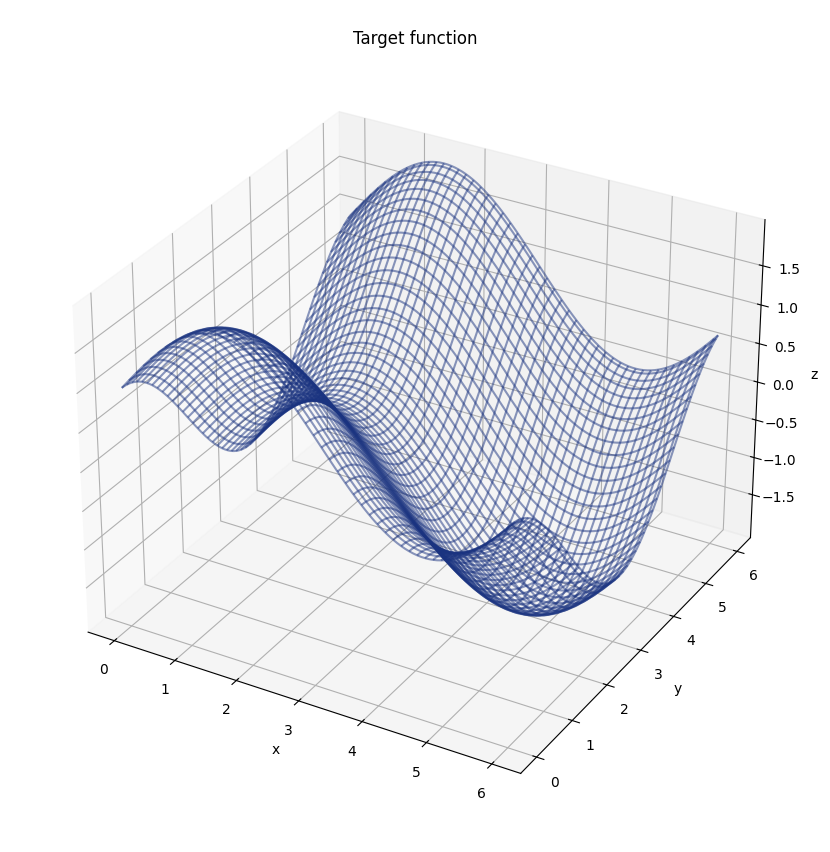

In [4]:
# Plot function surface
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
x, y = (np.linspace(LOW[dim], HIGH[dim], 100) for dim in range(2))
x, y = np.meshgrid(x, y)
z = target(x, y)
true_surface = ax.plot_wireframe(x, y, z, color=(0.1, 0.2, 0.5, 0.5))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Target function')
plt.show()

## Implementing Tile Coding

The `TiledValueTable` class below is a very simple implementation of tile coding. The idea is that if we have an object `tvt` of type `TiledValueTable`,
we should be able to index it, just as we would a Q-table, but with continuous values instead: for example, `tvt[1.2, 3.4]` would return our approximation
for the value of the target function in $(1.2, 3,4)$. This can be calculated by determining which tile the input vector falls in for each tiling,
and adding up the values corresponding to those tiles. The `__getitem__` dunder method in Python can be used to implement this.

In addition to querying the table, we also have to be able to update our estimations: we want to be able to write `tvt[1.2, 3.4] = 6`, just as we do
with Q-tables. Since `tvt[1.2, 3.4]` is not a single value, but a sum of multiple tile-values, we should shift all of those values so that they
add up to the desired new value. The sum should be shifted by `new_value - old_value`, but since we have `n` different tilings, each tile-value
has to be shifted by only `(new_value - old_value) / n`. To implement this, we can use the `__setitem__` dunder method.

For both methods, we need to be able to determine for each tiling which tile does a certain vector fall into. This easily be implemented
with NumPy's `searchsorted` method.

Below there is a visualization of the tilings of the `tvt`. After that, we 'train' the table, by randomly sampling values from the input space,
calculating the target value with some added noise, and shifting the `tvt` value towards that target. Notice how the update looks exactly like a 
Q-learning update, even though under the hood it's quite different. Finally, we compare the target function to our approximations.

- Examples of the `__getitem__` and `__setitem__` methods: https://www.tutorialspoint.com/getitem-and-setitem-in-python
- Documentation for `np.searchsorted`: https://numpy.org/doc/stable/reference/generated/numpy.searchsorted.html

In [5]:
class TiledValueTable:
    def __init__(self, offsets, n_bins):
        self.tilings = []
        self.n_tilings = len(offsets)
        n_dims = len(offsets[0])

        # Create tilings
        for offset in offsets:
            tiling = [np.linspace(LOW[dim], HIGH[dim], n_bins + 1)[1:-1] + offset[dim] for dim in range(n_dims)]
            self.tilings.append(tiling)

        # Initialize value table
        shape = (self.n_tilings, ) + (n_bins, ) * n_dims
        self.value_table = np.zeros(shape)

    def __getitem__(self, args):
        val = 0

        # Sum up values in all tilings
        for i, tiling in enumerate(self.tilings):
            ind = [i]
            for dim in range(len(args)):
                ind.append(np.searchsorted(tiling[dim], args[dim]))
            val += self.value_table[tuple(ind)]

        return val

    def __setitem__(self, args, new):
        old = self.__getitem__(args)

        # Shift values in all tilings
        for i, tiling in enumerate(self.tilings):
            ind = [i]
            for dim in range(len(args)):
                ind.append(np.searchsorted(tiling[dim], args[dim]))
            self.value_table[tuple(ind)] += (new - old) / self.n_tilings

In [6]:
# Hyperparameters
N_TILINGS = 4  # Number of tilings
N_BINS = 12  # Number of bins per dimension per tiling
N_STEPS = 100_000  # Number of learning steps
ALPHA = 0.1  # Learning rate
NOISE = 0.1  # Variance of the target

In [7]:
# Set asymmetrical offsets to avoid artifacts in
# generalization; see Sutton & Barto pg. 218-220 for details
tile_width = (HIGH - LOW) / N_BINS
unit = tile_width / N_TILINGS
offsets = [(unit[0] * i, 3 * unit[1] * i) for i in range(N_TILINGS)]

# Initialize tiled value table
tvt = TiledValueTable(offsets, N_BINS)

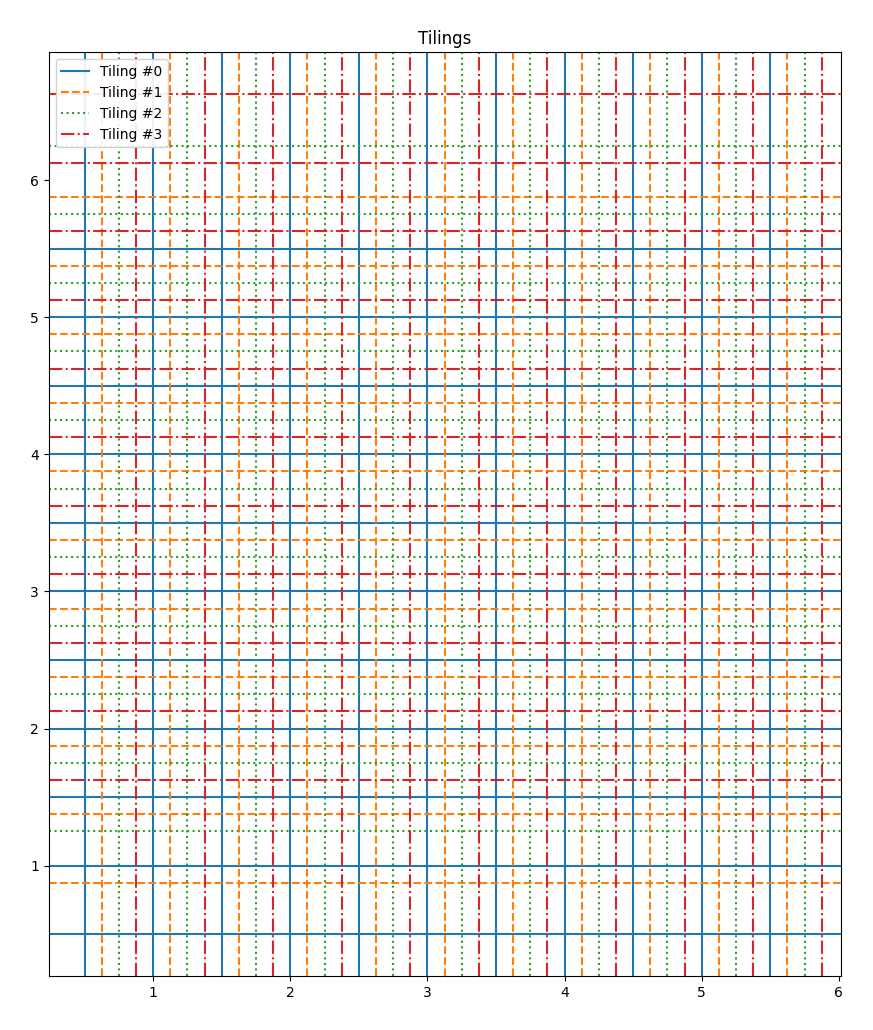

In [8]:
# Visualize tilings
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
linestyles = ['-', '--', ':', '-.']
legend_lines = []

fig, ax = plt.subplots(figsize=(12, 12))
for i, grid in enumerate(tvt.tilings):
    for x in grid[0]:
        line = ax.axvline(x=x, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
    for y in grid[1]:
        line = ax.axhline(y=y, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=i)
    legend_lines.append(line)

ax.legend(legend_lines, [f"Tiling #{t}" for t in range(len(legend_lines))], facecolor='white', framealpha=0.9)
ax.set_title("Tilings")
ax.set_aspect('equal', adjustable='box')

plt.show()

In [9]:
# Training
for _ in trange(N_STEPS):
    x, y = np.random.rand(2) * (HIGH - LOW) + LOW
    z = target(x, y) + np.random.normal(0, NOISE)  # Target function value + Gaussian noise
    tvt[x, y] += ALPHA * (z - tvt[x, y])

  0%|          | 0/100000 [00:00<?, ?it/s]

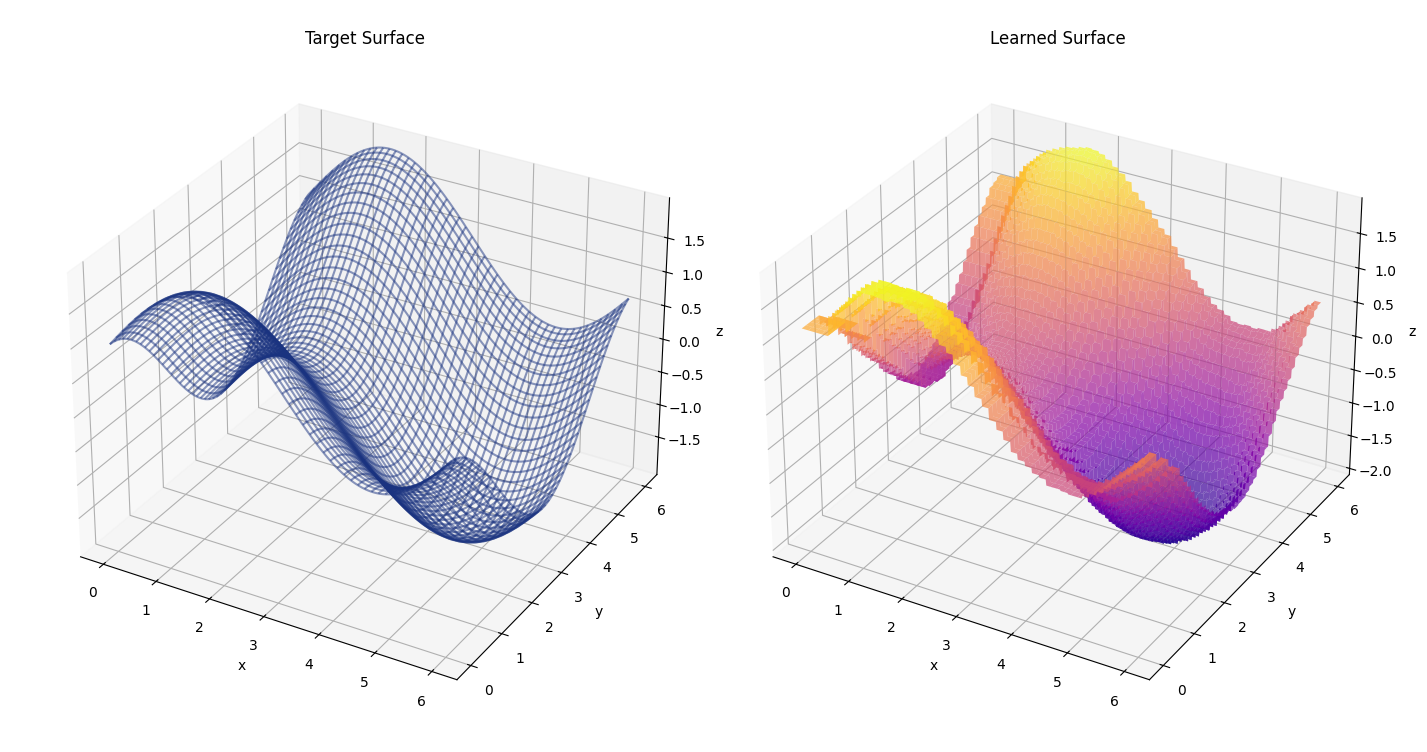

In [10]:
# Calculating target & learned values on the domain
x, y = (np.linspace(LOW[dim], HIGH[dim], (HIGH[dim] - LOW[dim]) * 100) for dim in range(2))
x, y = np.meshgrid(x, y)
z = target(x, y)

z_learned = np.zeros(x.shape)
for i in np.ndindex(x.shape):
    z_learned[i] = tvt[x[i], y[i]]

# Plot target surface
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121, projection='3d')
true_surface = ax.plot_wireframe(x, y, z,
                                 color=(0.1, 0.2, 0.5, 0.5),
                                 label='True values')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Target Surface')

# Plot learned surface
ax = fig.add_subplot(122, projection='3d')
learned_surface = ax.plot_surface(x, y, z_learned, cmap='plasma',
                                  alpha=.7, label='Learned values')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Learned Surface')

plt.tight_layout()
plt.show()